# Point in Polygon & Intersect

Finding out if a certain point is located inside or outside of an area,
or finding out if a line intersects with another line or polygon are
fundamental geospatial operations that are often used e.g. to select
data based on location. Such spatial queries are one of the typical
first steps of the workflow when doing spatial analysis. Performing a
spatial join (will be introduced later) between two spatial datasets is
one of the most typical applications where Point in Polygon (PIP) query
is used.

### Download data

For the lesson four **download data package from** [here](https://github.com/AutoGIS/data/raw/master/CSC/L4_data.zip).

The data package contains a KML-file called `PKS_suuralue.kml`, `addresses.shp`, and `Vaestotietoruudukko_2015.shp`.

## How to check if point is inside a polygon?

Computationally, detecting if a point is inside a polygon is most commonly done using a specific formula called [Ray Casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm).
Luckily, we do not need to create such a function ourselves for
conducting the Point in Polygon (PIP) query. Instead, we can take
advantage of [Shapely's binary predicates](http://toblerity.org/shapely/manual.html#binary-predicates)
that can evaluate the topolocical relationships between geographical
objects, such as the PIP as we're interested here.

There are basically two ways of conducting PIP in Shapely:

1. using a function called
   [.within()](http://toblerity.org/shapely/manual.html#object.within)
   that checks if a point is within a polygon
2. using a function called
   [.contains()](http://toblerity.org/shapely/manual.html#object.contains)_
   that checks if a polygon contains a point

Notice: even though we are talking here about **Point** in Polygon
operation, it is also possible to check if a LineString or Polygon is
inside another Polygon.

-  Let's first create a Polygon using a list of coordinate-tuples and a
   couple of Point objects

In [1]:
from shapely.geometry import Point, Polygon

# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

# Let's check what we have
print(p1)
print(p2)
print(poly)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


Let's check if those points are ``within`` the polygon

In [2]:
# Check if p1 is within the polygon using the within function
p1.within(poly)

# Check if p2 is within the polygon
p2.within(poly)

False

Okey, so we can see that the first point seems to be inside that polygon
and the other one doesn't.

-  In fact, the first point is close to the center of the polygon as we
   can see:

In [4]:
# Our point
print(p1)

# The centroid
print(poly.centroid)

POINT (24.952242 60.1696017)
POINT (24.95224242849236 60.16960179038188)


-  It is also possible to do PIP other way around, i.e. to check if
   polygon contains a point:

In [6]:
# Does polygon contain p1?
poly.contains(p1)

# Does polygon contain p2?
poly.contains(p2)

False

Thus, both ways of checking the spatial relationship results in the same way.

Which one should you use then? Well, it depends:

-  if you have many points and just one polygon and you try to find out
   which one of them is inside the polygon:

   -  you need to iterate over the points and check one at a time if it
      is **within()** the polygon specified

-  if you have many polygons and just one point and you want to find out
   which polygon contains the point

    -  you need to iterate over the polygons until you find a polygon that
       **contains()** the point specified (assuming there are no overlapping
       polygons)
        
## Intersect


Another typical geospatial operation is to see if a geometry
[intersect](http://toblerity.org/shapely/manual.html#object.intersects)
or [touches](http://toblerity.org/shapely/manual.html#object.touches)
another one. The difference between these two is that:

-  if objects intersect, the boundary and interior of an object needs to
   intersect in any way with those of the other.

-  If an object touches the other one, it is only necessary to have (at
   least) a single point of their boundaries in common but their
   interiors shoud NOT intersect.

Let's try these out.

-  Let's create two LineStrings

In [7]:
from shapely.geometry import LineString, MultiLineString

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])


-  Let's see if they intersect

In [8]:
line_a.intersects(line_b)

True

-  Do they also touch each other?

In [9]:
line_a.touches(line_b)

True

Indeed, they do and we can see this by plotting the features together

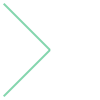

In [10]:
# Create a MultiLineString
multi_line = MultiLineString([line_a, line_b])
multi_line

Thus, the ``line_b`` continues from the same node ( (1,1) ) where ``line_a`` ends.

However, if the lines overlap fully, they don't touch due to the spatial relationship rule, as we can see:

- Check if line_a touches itself

In [11]:
# Does the line touch with itself?
line_a.touches(line_a)

False

- It does not. However, it does intersect

In [12]:
# Does the line intersect with itself?
line_a.intersects(line_a)

True

## Point in Polygon using Geopandas

Next we will do a practical example where we check which of the addresses from previous tutorial are located in Southern district of Helsinki. We will use a KML-file that has the Polygons for districts of Helsinki Region (data openly available from [Helsinki Region Infoshare](http://www.hri.fi/fi/dataset/paakaupunkiseudun-aluejakokartat).

- Let's start by reading the addresses from the Shapefile that we saved earlier.

In [3]:
import geopandas as gpd
fp = "L4_data/addresses.shp"
data = gpd.read_file(fp)


### Reading KML-files in Geopandas

It is possible to read the data from KML-file in a similar manner as Shapefile. However, we need to first, enable the KML-driver which is not enabled by default (because KML-files can contain unsupported data structures, nested folders etc., hence be careful when reading KML-files).

- Let's enable the read and write functionalities for KML-driver by passing ``'rw'`` to whitelist of fiona's supported drivers:









In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

Now we should be able to read a KML file with Geopandas.

- Let's read the data from a following KML -file:

In [6]:
# Filepath to KML file
fp = "L4_data/PKS_suuralue.kml"

polys = gpd.read_file(fp, driver='KML')
polys

,Name,Description,geometry
0,Suur-Espoonlahti,,POLYGON Z ((24.775059677807 60.1090604462157 0...
1,Suur-Kauklahti,,POLYGON Z ((24.6157775254076 60.1725681273527 ...
2,Vanha-Espoo,,POLYGON Z ((24.6757633262026 60.2120070032819 ...
3,Pohjois-Espoo,,POLYGON Z ((24.767921197401 60.2691954732391 0...
4,Suur-Matinkylä,,POLYGON Z ((24.7536131356802 60.1663051341717 ...
5,Kauniainen,,POLYGON Z ((24.6907528033566 60.2195779731868 ...
6,Suur-Leppävaara,,POLYGON Z ((24.797472695835 60.2082651196077 0...
7,Suur-Tapiola,,POLYGON Z ((24.8443596422129 60.1659790707387 ...
8,Myyrmäki,,POLYGON Z ((24.8245867448802 60.2902531157585 ...
9,Kivistö,,POLYGON Z ((24.9430919106369 60.3384471629062 ...


Nice, now we can see that we have 22 districts in our area. We are interested in an area that is called ``Eteläinen`` (*'Southern'* in english).

- Let's select that one and see where it is located, and plot also the points on top of the map.

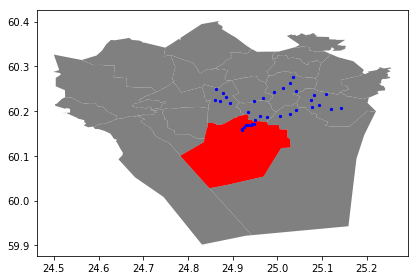

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Select 'Eteläinen' district (Southern)
southern = polys.loc[polys['Name']=='Eteläinen']
southern.reset_index(drop=True, inplace=True)

# Create plot
ax = polys.plot(facecolor='gray');
southern.plot(ax=ax, facecolor='red');
data.plot(ax=ax, color='blue', markersize=5);
plt.tight_layout()

Okey, so we can see that, indeed, certain points are within the selected red Polygon.

Let's find out which one of them are located within the Polygon. Hence, we are conducting a Point in Polygon query.

- Let's first enable shapely.speedups which makes some of the spatial queries running faster.

In [9]:
import shapely.speedups
shapely.speedups.enable()


- Let's check which Points are within the `southern` Polygon. Notice, that here we check if the Points are `within` the **geometry** of the `southern` GeoDataFrame. Hence, we use the `loc[0, 'geometry']` to parse the actual Polygon geometry object from the GeoDataFrame.

In [11]:
# Create a mask
pip_mask = data.within(southern.loc[0, 'geometry'])
print(pip_mask)

0      True
1      True
2     False
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
34    False
dtype: bool


As we can see, we now have an array of boolean values for each row, where the result is ``True``
if Point was inside the Polygon, and ``False`` if it was not.

- We can now use this mask array to select the Points that are inside the Polygon. Selecting data with this kind of mask array (of boolean values) is
  easy by passing the array inside the ``loc`` indexing function of Pandas.


In [12]:
# Select points that are within Polygon
pip_data = data.loc[pip_mask]
pip_data

,address,id,geometry
0,"Kampinkuja 1, 00100 Helsinki, Finland",1001,POINT (24.9301701 60.1683731)
1,"Kaivokatu 8, 00101 Helsinki, Finland",1002,POINT (24.9418933 60.1698665)
4,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",1005,POINT (24.9214846 60.1565781)
10,"Rautatientori 1, 00100 Helsinki, Finland",1011,POINT (24.94251 60.1711874)
30,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",1031,POINT (24.9337569 60.1694809)
31,"Gräsviksgatan 17, 00101 Helsingfors, Finland",1032,POINT (24.9250072 60.16500139999999)
32,"Stillahavsgatan 3, 00220 Helsingfors, Finland",1033,POINT (24.9214046 60.159069)
33,"Vilhelmsgatan 4, 00101 Helsingfors, Finland",1034,POINT (24.9468514 60.1719108)


Let's finally confirm that our Point in Polygon query worked as it should by plotting the data.

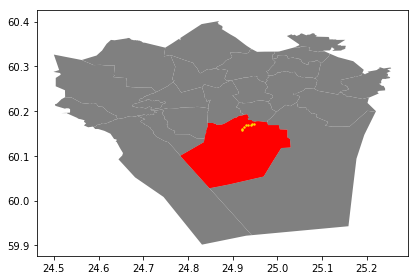

In [17]:
# Plot
ax = polys.plot(facecolor='gray')
southern.plot(ax=ax, facecolor='red')
pip_data.plot(ax=ax, color='gold', markersize=2)
plt.tight_layout()

Perfect! Now we only have the (golden) points that, indeed, are inside the red Polygon which is exactly what we wanted!